In this vignette, we use **varbvs** to map QTLs for phenotypesmeasured in CFW (Carworth Farms White) outbred mice. Phenotypes include muscle weights---EDL and soleus muscle---and testis weight measured at sacrifice. In the report we set target trait as 'testis' and covariates as 'sacwt' to reproduce the results and figures shown in the second example of the original paper. Besides, we set the same hyperparameters **logodds** and **sa**.. 
To run this notebook, the pheno data 'pheno.csv' and the genodata 'geno.csv' 'map.csv' 'gwscan.bvsr.csv','gwscan.gemma.csv'should be put in the folder 'data' .

Begin by loading packages and my implementation in to the environment.

In [1]:
import numpy as np
import pandas as pd
import varbvs

Set target trait, covariates and hyperparameters.

In [2]:
trait = 'testis'
covariate = 'sacwt'
logodds = np.linspace(-5, -3, 9)
sa = 0.05

Set the random number generator seed for varbvs.

In [3]:
seed = 2

Load the phenotype and snp data, analyze for which the phenotype and all the covariates are observed. Here we in advance transformed the original Rdata into several .csv files.

In [4]:
pheno = pd.read_csv('data/pheno.csv', index_col=0)
geno = pd.read_csv('data/geno.csv', index_col=0)

rows = pheno[[trait, covariate]].isna().any(axis=1)
rows = rows[rows == False].index

pheno = pheno.loc[rows]
geno = geno.loc[rows]

In [5]:
print('shape of geno: ', geno.shape)
print('shape of pheno: ', pheno.shape)
print(pheno.head())

shape of geno:  (993, 79748)
shape of pheno:  (993, 7)
       sacwt  batch16  tibia   edl  soleus  testis  abnormal.bmd
26305   46.6      0.0  19.05  16.9     NaN  0.1396           0.0
26306   35.7      0.0  18.06  13.2     8.5  0.1692           0.0
26307   34.1      0.0  18.14  11.2     6.8  0.1878           0.0
26308   41.8      0.0  18.18  12.9     8.7  0.2002           0.0
26309   39.5      0.0  18.35  14.1     9.2  0.1875           0.0


Set and fit the model. This process will take about 4 minutes.

In [6]:
model = varbvs.varbvs(geno.to_numpy(), pheno[trait].to_numpy(), pheno[covariate].to_numpy().reshape((993, 1)))

In [7]:
pip=model.fit(sa=0.05, logodds=logodds, seed=seed, verbose=True)

first stage optimization
1th setting: logw: 2423.1401070990905, sigma: 0.0004203054722291883, sa: 0.05, n_iter: 14
2th setting: logw: 2424.1097160912805, sigma: 0.0004177494325950426, sa: 0.05, n_iter: 23
3th setting: logw: 2425.3612485649273, sigma: 0.0004106769416956187, sa: 0.05, n_iter: 37
4th setting: logw: 2426.586566728537, sigma: 0.00040565738130918623, sa: 0.05, n_iter: 34
5th setting: logw: 2427.9366089414293, sigma: 0.0003975109042888437, sa: 0.05, n_iter: 26
6th setting: logw: 2428.709262900894, sigma: 0.00038939605999309206, sa: 0.05, n_iter: 18
7th setting: logw: 2421.89877380724, sigma: 0.00037758418735559624, sa: 0.05, n_iter: 26
8th setting: logw: 2419.0462388840956, sigma: 0.0003656633479601881, sa: 0.05, n_iter: 27
9th setting: logw: 2408.773664379219, sigma: 0.0003497110659901976, sa: 0.05, n_iter: 83
second stage optimization
1th setting: logw: 2423.1158064367155, sigma: 0.00041844065588741676, sa: 0.05, n_iter: 19
2th setting: logw: 2424.1914869518932, sigma: 0.00

In [8]:
print(pip.argmax())
sorted = np.argsort(pip)[::-1]
print(sorted[:10])
print(pip[sorted[:10]])

59248
[59248 24951  9202 67414 44314 25416 42595 14017 59177 43025]
[1.         0.93513311 0.68685054 0.07392288 0.0707774  0.06642983
 0.03844532 0.03422342 0.0335315  0.02919108]


Show three genome-wide scans: (1) one using the posterior inclusion
probabilities (PIPs) computed in the BVS analysis of all SNPs; (2)
one using the p-values computed using GEMMA; and (3) one using the
PIPs computed from the BVSR model in GEMMA. Here the results of (2) 
and (3) generated by GEMMA are directly from the original paper.

In [9]:
map = pd.read_csv('data/map.csv', index_col=0)
gwscan_bvsr = pd.read_csv('data/gwscan.bvsr.csv')
gwscan_gemma = pd.read_csv('data/gwscan.gemma.csv')

To draw the manhatton plot, we use the visuz module in bioinfokit package

In [10]:
from bioinfokit import visuz
show = True

Setting 'show' as True will show the figure and setting 'show' as False will download the figure in the current folder.

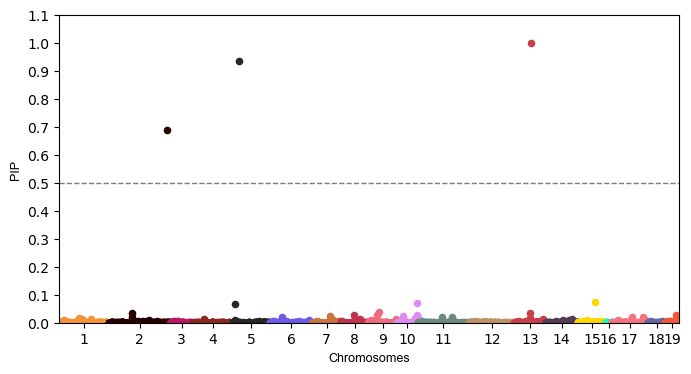

In [11]:
df_varbvs = pd.DataFrame({'snp': map['id'], 'chr': map['chr'], 'pos': map['pos'], 'p': pip})
visuz.marker.mhat(df=df_varbvs, chr='chr',pv='p', gwas_sign_line=True, log_scale=False, gwasp=0.1**0.5, show=show, ylm=(0, 1.2, 0.1), axylabel='PIP', ar=0, dim=(8, 4), figname='multimarker(varbvs)', dotsize=20)

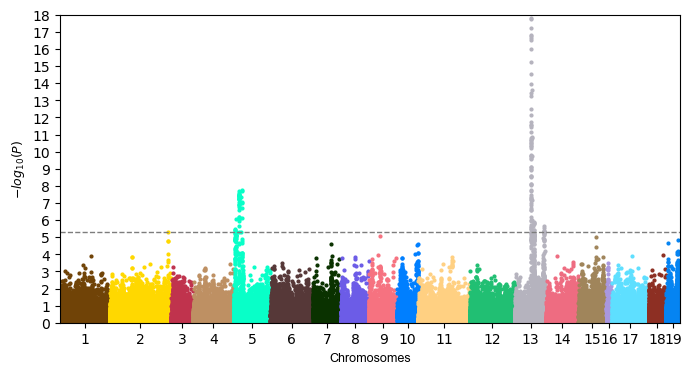

In [12]:
r = gwscan_gemma['testis'].to_numpy()
df_gemma = pd.DataFrame({'snp': map['id'], 'chr': map['chr'], 'pos': map['pos'], 'score': r})
visuz.marker.mhat(df=df_gemma, chr='chr',pv='score', log_scale=False, show=show, ar=0, dim=(8, 4), figname='singlemarker(gemma)', dotsize=4, gwas_sign_line=True, gwasp= 5e-6)

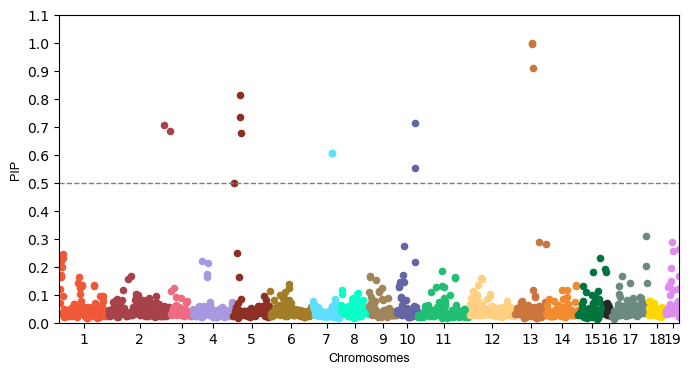

In [13]:
p = gwscan_bvsr['p1'].to_numpy()
df_bvsr = pd.DataFrame({'chr': gwscan_bvsr['chr'], 'pos': gwscan_bvsr['pos'], 'pv': p})
visuz.marker.mhat(df=df_bvsr, chr='chr',pv='pv', log_scale=False, show=show, ar=0, dim=(8, 4), figname='multimarker(bvsr)', dotsize=20, gwas_sign_line=True, gwasp= 0.1**0.5, ylm=(0, 1.2, 0.1), axylabel='PIP')

In [14]:
print(model.w)
print(model.sigma)
print(model.y.var()) 
print(model.logodds)   

[1.62522227e-03 4.76513135e-03 1.61140163e-02 5.92706555e-02
 2.01632572e-01 4.36636504e-01 2.70589452e-01 9.36573141e-03
 7.14075626e-07]
[0.00041844 0.00041442 0.00040974 0.00040418 0.00039751 0.0003894
 0.00037943 0.00036708 0.00035165]
0.000459459490265851
[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.  ]


In [15]:
print(model.mu)

[[-5.01901512e-05 -1.12691923e-04 -1.43009674e-04 ... -8.96648363e-05
  -1.05168085e-04 -1.34030333e-04]
 [-3.21853688e-04 -3.15073963e-04 -3.10243180e-04 ... -3.14257938e-04
  -3.20372646e-04 -3.25197697e-04]
 [-9.89321533e-04 -9.94979192e-04 -1.00018577e-03 ... -9.85847278e-04
  -9.59789413e-04 -9.18464843e-04]
 ...
 [-4.97468149e-04 -4.85212821e-04 -4.59308219e-04 ... -2.79048929e-04
  -2.41784505e-04 -2.10264154e-04]
 [-1.00122561e-04 -6.57366520e-05 -3.83305523e-05 ...  6.35111536e-07
   2.71633757e-06  6.97273930e-06]
 [ 1.27747435e-03  1.26345400e-03  1.24558654e-03 ...  1.10292918e-03
   1.04510932e-03  9.77241704e-04]]
